__Author__:Bogdan Bintu, Adam Jussila, Colin Kern

__Date__:03/22/2021

__Scope__: Analysis tools for Chromatin Tracing

<h3>Pipeline setup</h3>

This pipeline requires the following additional packages to be installed in the python environment: pytorch, py-opencv

These can be installed with this command in the anaconda prompt:

`conda install pytorch py-opencv`

<h4>Set the folder with the raw data</h4>

In [1]:
master_folders = ['path/to/data']

<h4>Set the folder for the analysis results</h4>

In [2]:
analysis_folder = 'path/to/analysis_folder'

<h4>Specify colors used in this experiment</h4>

In [3]:
colors = ['750','647','561','beads']

<h3>Initialize the pipeline</h3>

In [4]:
import sys, os

sys.path.append('path/to/CommonTools')

import PipelineFunctions as pipeline
import QCTools as qct
import matplotlib.pylab as plt
from scipy.spatial.distance import squareform,pdist,cdist
from scipy.stats import ranksums
folders, fovs, h0_folder = pipeline.load_data(master_folders, analysis_folder)

In C:\Users\Administrator\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Administrator\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Administrator\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Administrator\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Administrator\Anaconda3\lib\site-packages\matplo

Found 14 folders.


<h3>Nuclei segmentation</h3>

In [37]:
#Load the CNN model
model = pipeline.seg.get_model(r'D:\ChromatinTracingPipeline\edge_HCT15_last')

C:\Users\Administrator\Anaconda3\lib\site-packages\torch\nn\functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


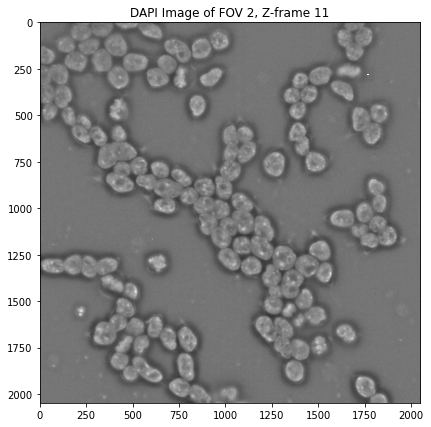

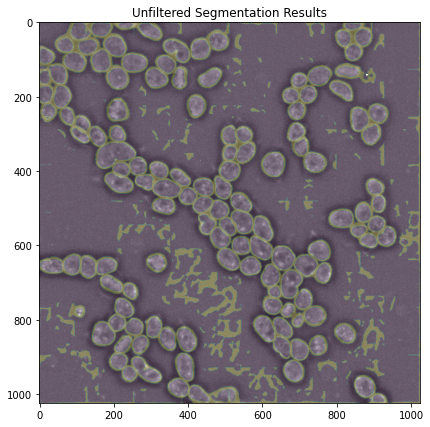

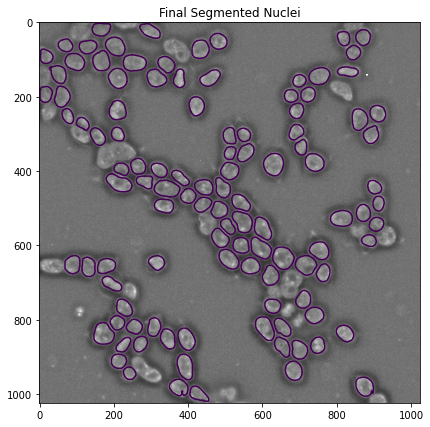

In [38]:
##########
test_fov = 2     # Test segmentation on this FOV
z_frame = 11     # Use this z-slice for segmentation (find one that isn't too blurry)

#These are the parameters for filtering the segmentation results
imf_thresh = 0.075  #Threshold of the edge image to binarize the edges. Better to be more conservative.
min_area = 800     #Minimum area in pixels that a nuclei can be
max_area = 3500    #Maximum area in pixels that a nuclei can be
solidity_th = 0.95   #How "round" the cell is, and varies from 0-1 (higher is more round)
infocus_fraction_th = 0 #? No notes from Bogdan, maybe shouldn't be changed
##########

ims = pipeline.load_dapi_dax_frame(h0_folder, fovs, frame=z_frame)
test_im = pipeline.seg.blurnorm2d(ims[test_fov],75)
imf = pipeline.seg.segment_fov(ims[test_fov], model)
test_im_resized = pipeline.seg.blurnorm2d(ims[test_fov],75)[::2,::2] # normalize and resize image.
im_label = pipeline.seg.filter_segmented_fov(imf, imf_thresh=imf_thresh, min_area=min_area, max_area=max_area, 
                                             solidity_th=solidity_th, infocus_fraction_th=infocus_fraction_th)

%matplotlib inline
plt.figure(figsize=(7,7))
plt.imshow(test_im,vmax=2,cmap='gray')
plt.title(f"DAPI Image of FOV {test_fov}, Z-frame {z_frame}")

plt.figure(figsize=(7,7))
plt.imshow(test_im_resized,vmax=2,cmap='gray')
plt.imshow(imf>0.1,alpha=0.2)
plt.title(f"Unfiltered Segmentation Results")

plt.figure(figsize=(7,7))
plt.imshow(test_im_resized,cmap='gray',vmax=2)
plt.contour(im_label>0,[0.5])
plt.title(f"Final Segmented Nuclei");

In [39]:
#Do segmentation on all FOVs (~20 seconds per FOV)
pipeline.seg.run_segmentation(analysis_folder, ims, model, imf_thresh=imf_thresh, min_area=min_area, max_area=max_area, 
                              solidity_th=solidity_th, infocus_fraction_th=infocus_fraction_th)

### Compute the flat field correction

In [40]:
#Fast, 1-2 seconds per FOV
im_meds = pipeline.save_median_image_across_fovs(folders, analysis_folder)

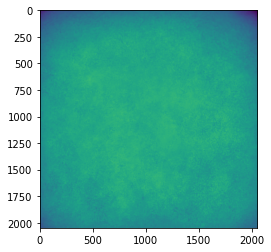

In [41]:
#Visualize median images
im = im_meds[3] # 0-3 is [750, 647, 561, 488] nm (laser wavelength)
plt.figure()
plt.imshow(im,vmax=8000);

In [42]:
#This step takes a long time (~30 minutes per FOV for an experiment with 45 probes)
pipeline.flat_field_correction(folders, analysis_folder, fovs, colors)

Conv_zscan_00.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_00_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_00_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_00_mean_2.dax



Conv_zscan_01.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_01_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_01_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_01_mean_2.dax



Conv_zscan_02.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_02_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_02_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_02_mean_2.dax



Conv_zscan_03.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_03_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_03_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_03_mean_2.dax



Conv_zscan_04.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_04_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_04_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_04_mean_2.dax



Conv_zscan_05.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_05_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_05_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_05_mean_2.dax



Conv_zscan_06.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_06_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_06_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_06_mean_2.dax



Conv_zscan_07.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_07_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_07_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_07_mean_2.dax



Conv_zscan_08.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_08_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_08_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_08_mean_2.dax



Conv_zscan_09.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_09_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_09_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_09_mean_2.dax



Conv_zscan_10.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_10_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_10_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_10_mean_2.dax



Conv_zscan_11.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_11_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_11_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_11_mean_2.dax



Conv_zscan_12.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_12_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_12_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_12_mean_2.dax



Conv_zscan_13.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_13_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_13_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_13_mean_2.dax



Conv_zscan_14.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_14_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_14_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_14_mean_2.dax



Conv_zscan_15.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_15_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_15_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_15_mean_2.dax



Conv_zscan_16.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_16_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_16_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_16_mean_2.dax



Conv_zscan_17.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_17_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_17_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_17_mean_2.dax



Conv_zscan_18.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_18_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_18_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_18_mean_2.dax



Conv_zscan_19.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_19_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_19_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_19_mean_2.dax



Conv_zscan_20.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_20_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_20_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_20_mean_2.dax



Conv_zscan_21.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_21_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_21_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_21_mean_2.dax



Conv_zscan_22.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_22_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_22_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_22_mean_2.dax



Conv_zscan_23.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_23_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_23_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_23_mean_2.dax



Conv_zscan_24.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_24_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_24_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_24_mean_2.dax



Conv_zscan_25.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_25_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_25_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_25_mean_2.dax



Conv_zscan_26.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_26_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_26_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_26_mean_2.dax



Conv_zscan_27.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_27_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_27_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_27_mean_2.dax



Conv_zscan_28.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_28_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_28_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_28_mean_2.dax



Conv_zscan_29.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_29_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_29_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_29_mean_2.dax



Conv_zscan_30.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_30_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_30_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_30_mean_2.dax



Conv_zscan_31.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_31_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_31_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_31_mean_2.dax



Conv_zscan_32.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_32_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_32_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_32_mean_2.dax



Conv_zscan_33.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_33_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_33_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_33_mean_2.dax



Conv_zscan_34.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_34_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_34_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_34_mean_2.dax



Conv_zscan_35.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_35_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_35_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_35_mean_2.dax



Conv_zscan_36.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_36_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_36_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_36_mean_2.dax



Conv_zscan_37.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_37_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_37_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_37_mean_2.dax



Conv_zscan_38.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_38_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_38_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_38_mean_2.dax



Conv_zscan_39.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_39_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_39_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_39_mean_2.dax



Conv_zscan_40.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_40_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_40_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_40_mean_2.dax



Conv_zscan_41.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_41_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_41_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_41_mean_2.dax



Conv_zscan_42.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_42_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_42_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_42_mean_2.dax



Conv_zscan_43.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_43_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_43_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_43_mean_2.dax



Conv_zscan_44.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_44_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_44_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_44_mean_2.dax



Conv_zscan_45.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_45_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_45_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_45_mean_2.dax



Conv_zscan_46.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_46_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_46_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_46_mean_2.dax



Conv_zscan_47.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_47_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_47_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_47_mean_2.dax



Conv_zscan_48.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_48_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_48_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_48_mean_2.dax



Conv_zscan_49.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_49_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_49_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_49_mean_2.dax



Conv_zscan_50.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_50_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_50_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_50_mean_2.dax



Conv_zscan_51.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_51_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_51_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_51_mean_2.dax



Conv_zscan_52.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_52_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_52_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_52_mean_2.dax



Conv_zscan_53.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_53_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_53_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_53_mean_2.dax



Conv_zscan_54.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_54_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_54_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_54_mean_2.dax



Conv_zscan_55.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_55_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_55_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_55_mean_2.dax



Conv_zscan_56.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_56_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_56_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_56_mean_2.dax



Conv_zscan_57.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_57_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_57_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_57_mean_2.dax



Conv_zscan_58.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_58_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_58_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_58_mean_2.dax



Conv_zscan_59.dax
D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_59_mean_0.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_59_mean_1.dax



D:\DNA_FISH\E20210225_D0047_S2\Analysis_AJ\Conv_zscan_59_mean_2.dax


<h3>Select candidate spots</h3>

In [7]:
# select two best colors (0 is first color in imaging round, 1 is second, etc.)
colors_to_use = [0,1]

In [8]:
#~70 seconds per FOV
pipeline.get_candidate_spots(analysis_folder, colors=colors_to_use)

C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:606: RuntimeWarning: invalid value encountered in true_divide
  im_ =im_/im_blur-1
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:625: RuntimeWarning: invalid value encountered in greater
  z,x,y = np.where(im_norm>hcutoff) # finay any positions where the brightness exceeds this value.
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:636: RuntimeWarning: invalid value encountered in greater_equal
  keep &= (h_im>=im_norm[(z+deltaz)%sz,(x+deltax)%sx,(y+deltay)%sy])
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:606: RuntimeWarning: invalid value encountered in true_divide
  im_ =im_/im_blur-1
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:625: RuntimeWarning: invalid value encountered in greater
  z,x,y = np.whe

C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:625: RuntimeWarning: invalid value encountered in greater
  z,x,y = np.where(im_norm>hcutoff) # finay any positions where the brightness exceeds this value.
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:636: RuntimeWarning: invalid value encountered in greater_equal
  keep &= (h_im>=im_norm[(z+deltaz)%sz,(x+deltax)%sx,(y+deltay)%sy])
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:606: RuntimeWarning: invalid value encountered in true_divide
  im_ =im_/im_blur-1
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:625: RuntimeWarning: invalid value encountered in greater
  z,x,y = np.where(im_norm>hcutoff) # finay any positions where the brightness exceeds this value.
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:

C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:606: RuntimeWarning: invalid value encountered in true_divide
  im_ =im_/im_blur-1
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:625: RuntimeWarning: invalid value encountered in greater
  z,x,y = np.where(im_norm>hcutoff) # finay any positions where the brightness exceeds this value.
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:636: RuntimeWarning: invalid value encountered in greater_equal
  keep &= (h_im>=im_norm[(z+deltaz)%sz,(x+deltax)%sx,(y+deltay)%sy])
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:606: RuntimeWarning: invalid value encountered in true_divide
  im_ =im_/im_blur-1
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:625: RuntimeWarning: invalid value encountered in greater
  z,x,y = np.whe

C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:625: RuntimeWarning: invalid value encountered in greater
  z,x,y = np.where(im_norm>hcutoff) # finay any positions where the brightness exceeds this value.
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:636: RuntimeWarning: invalid value encountered in greater_equal
  keep &= (h_im>=im_norm[(z+deltaz)%sz,(x+deltax)%sx,(y+deltay)%sy])
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:606: RuntimeWarning: invalid value encountered in true_divide
  im_ =im_/im_blur-1
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:625: RuntimeWarning: invalid value encountered in greater
  z,x,y = np.where(im_norm>hcutoff) # finay any positions where the brightness exceeds this value.
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:

C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:606: RuntimeWarning: invalid value encountered in true_divide
  im_ =im_/im_blur-1
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:625: RuntimeWarning: invalid value encountered in greater
  z,x,y = np.where(im_norm>hcutoff) # finay any positions where the brightness exceeds this value.
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:636: RuntimeWarning: invalid value encountered in greater_equal
  keep &= (h_im>=im_norm[(z+deltaz)%sz,(x+deltax)%sx,(y+deltay)%sy])
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:606: RuntimeWarning: invalid value encountered in true_divide
  im_ =im_/im_blur-1
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:625: RuntimeWarning: invalid value encountered in greater
  z,x,y = np.whe

C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:625: RuntimeWarning: invalid value encountered in greater
  z,x,y = np.where(im_norm>hcutoff) # finay any positions where the brightness exceeds this value.
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:636: RuntimeWarning: invalid value encountered in greater_equal
  keep &= (h_im>=im_norm[(z+deltaz)%sz,(x+deltax)%sx,(y+deltay)%sy])
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:606: RuntimeWarning: invalid value encountered in true_divide
  im_ =im_/im_blur-1
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:625: RuntimeWarning: invalid value encountered in greater
  z,x,y = np.where(im_norm>hcutoff) # finay any positions where the brightness exceeds this value.
C:\Users\Administrator\Analysis\ChromatinTracingPipeline_Underdev\CommonTools\FittingTools.py:

<h4>Check PNG files with names ending in "spots_selected_final" in the analysis folder to view candidate spots selected</h4>

<h3>Drift correction</h3>

In [9]:
#The 'jobs' parameter is how many FOVs to run simultaneously. 
#Each batch of jobs takes a few hours. No progress bar or any output is shown while running.
pipeline.drift_correction_batch(folders, analysis_folder, colors, jobs=17)

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


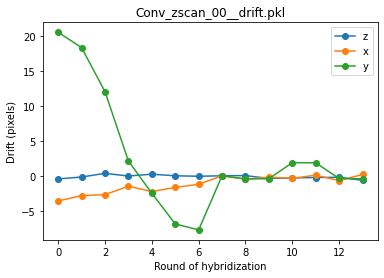

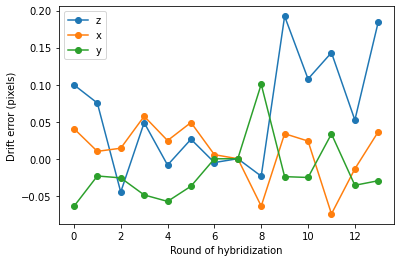

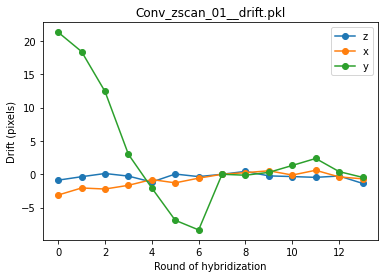

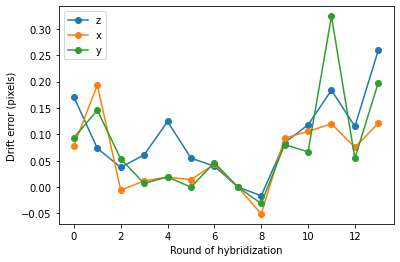

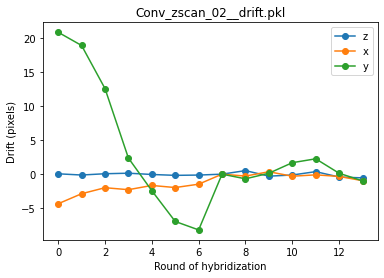

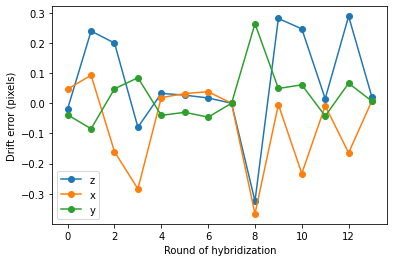

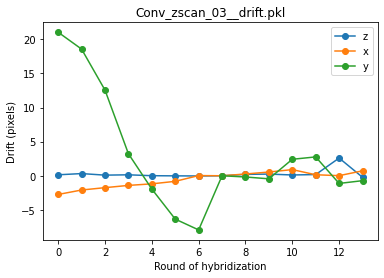

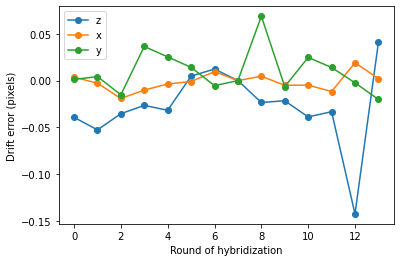

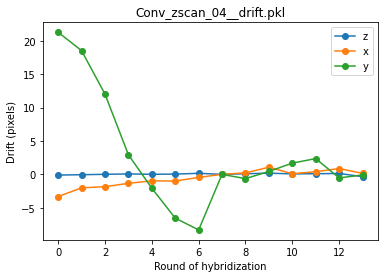

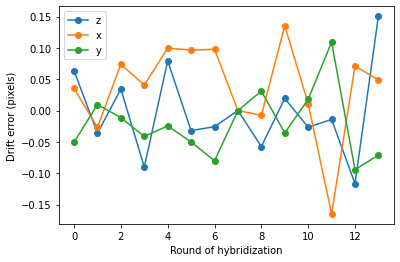

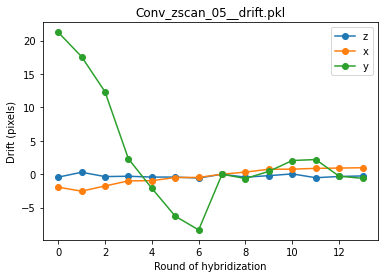

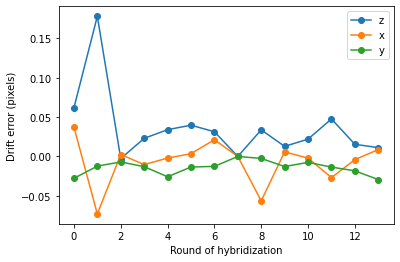

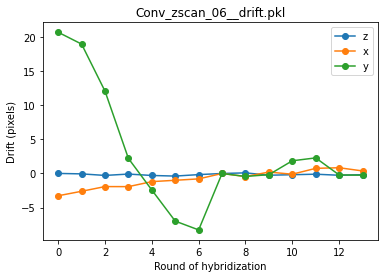

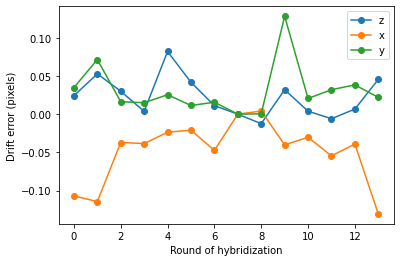

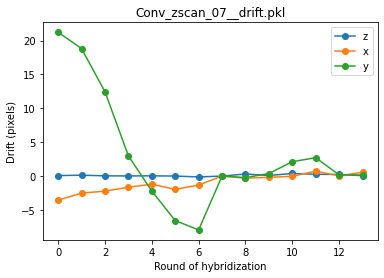

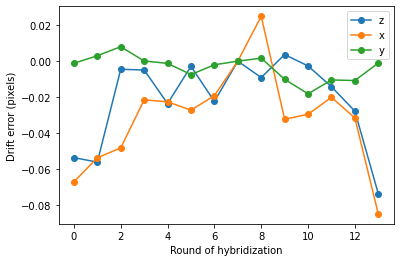

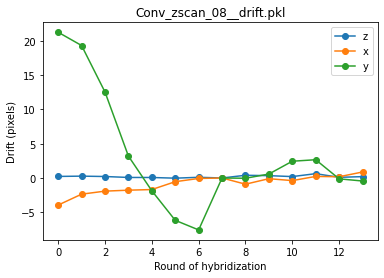

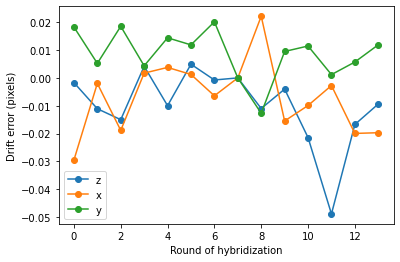

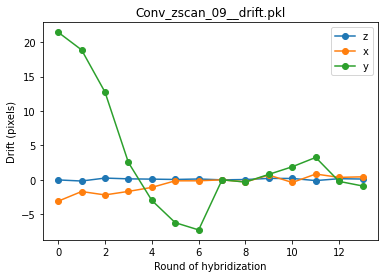

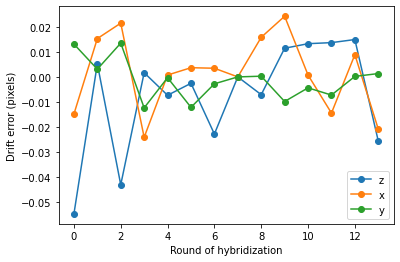

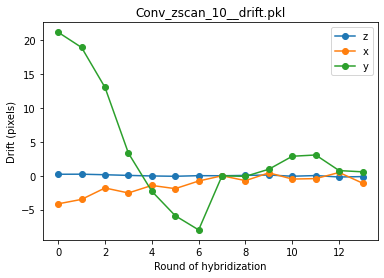

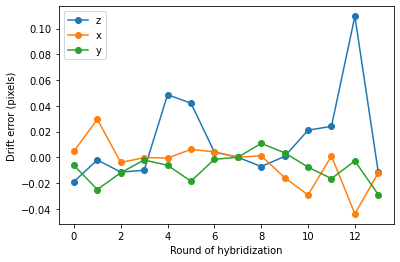

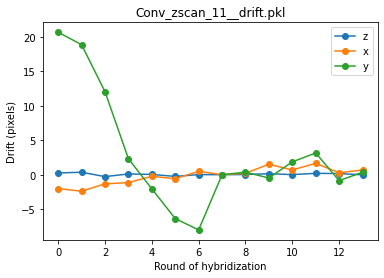

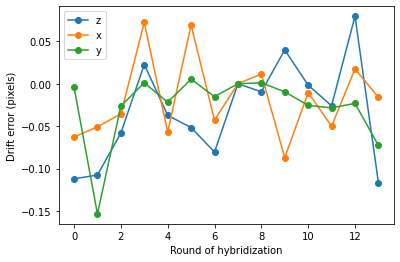

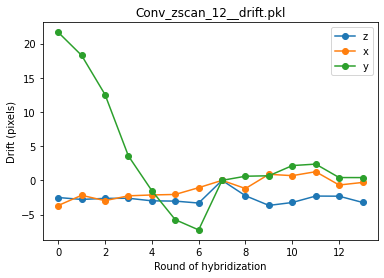

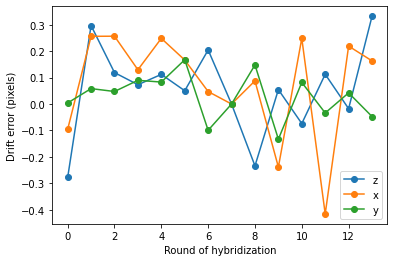

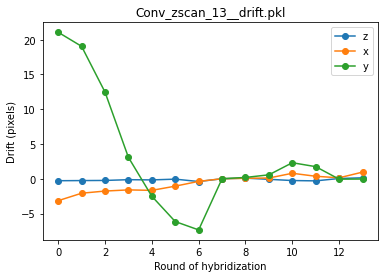

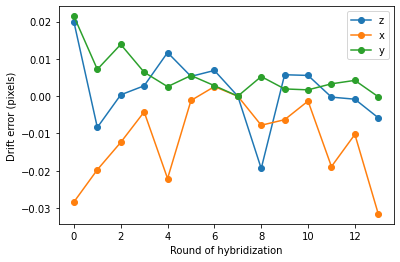

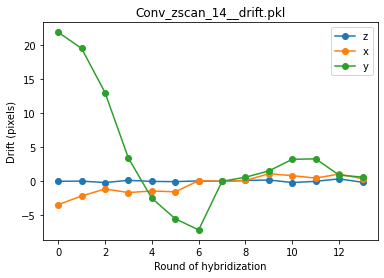

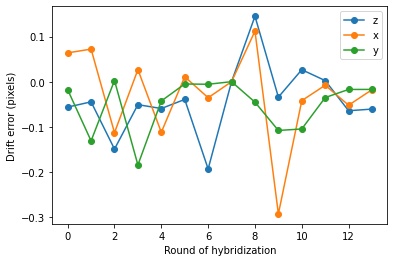

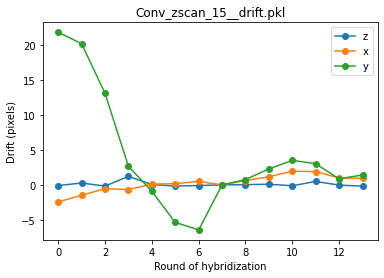

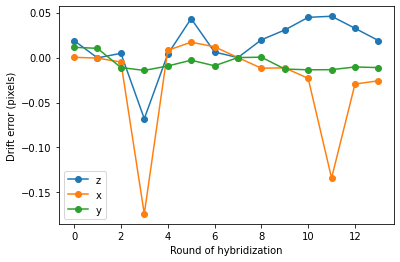

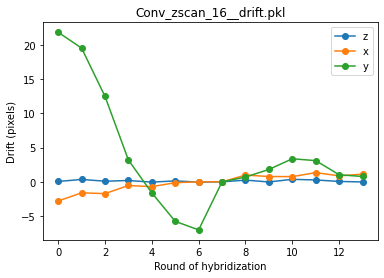

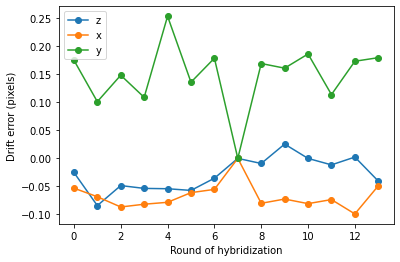

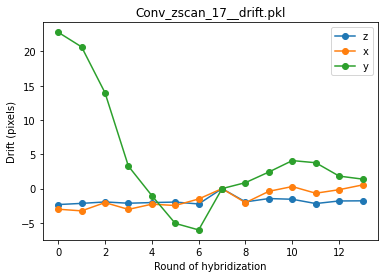

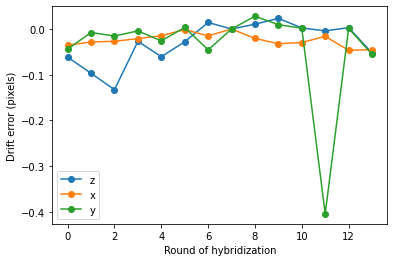

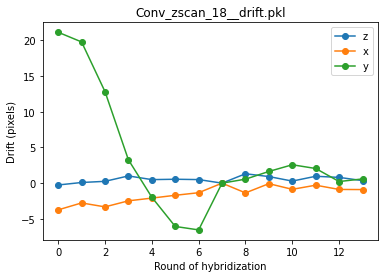

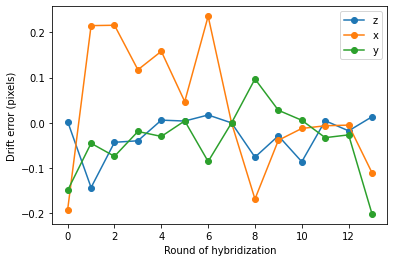

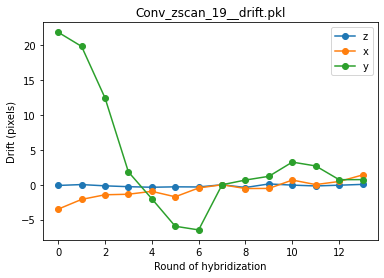

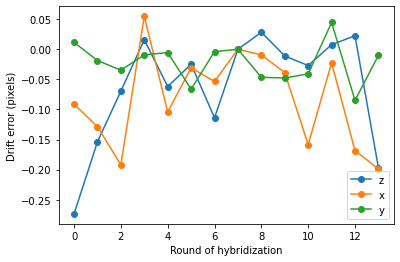

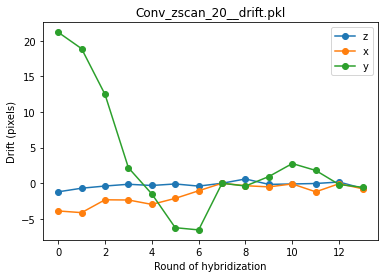

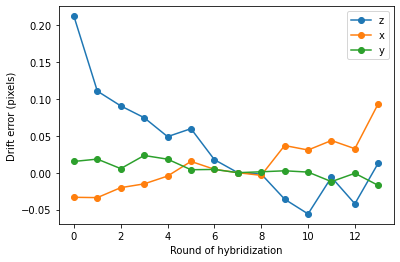

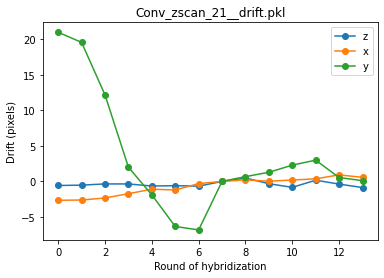

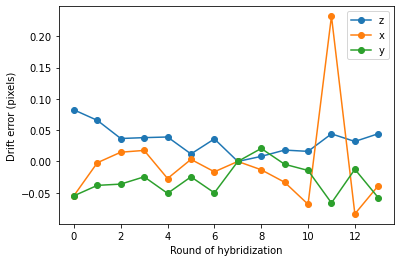

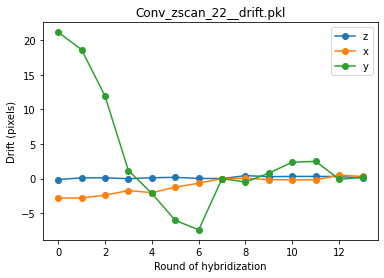

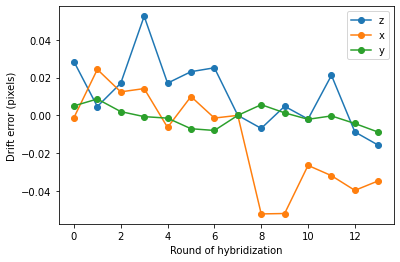

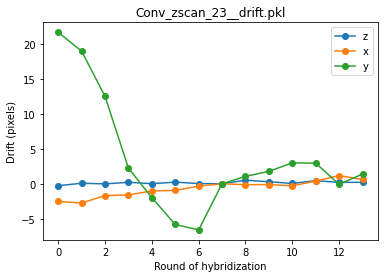

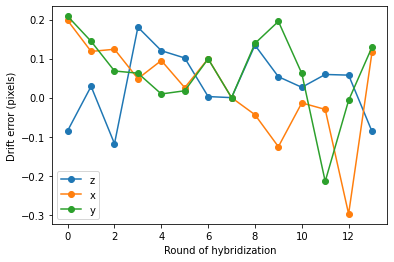

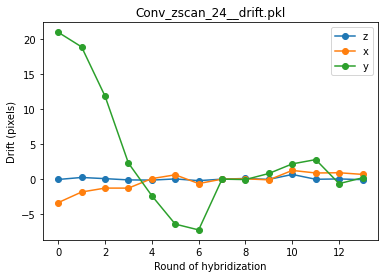

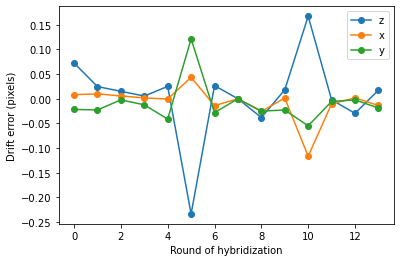

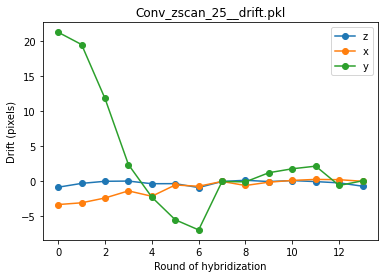

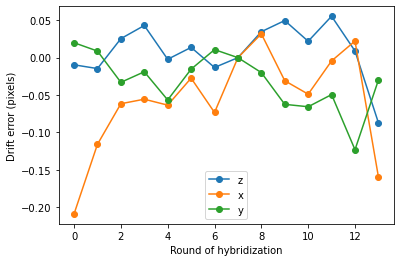

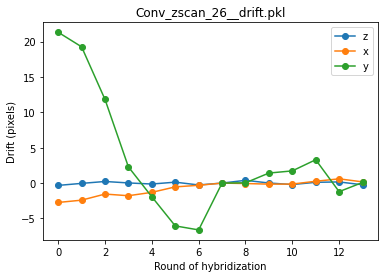

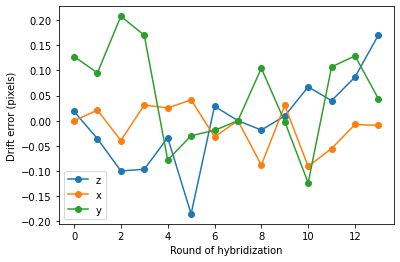

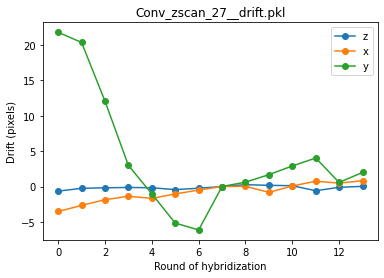

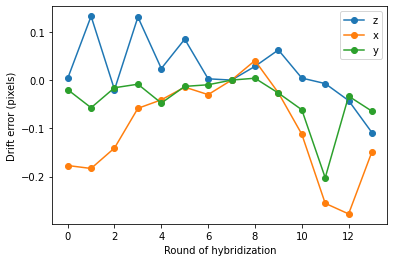

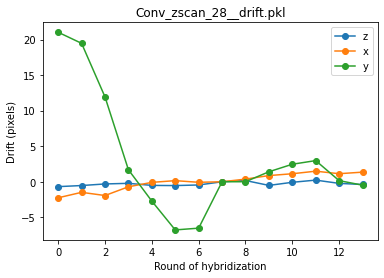

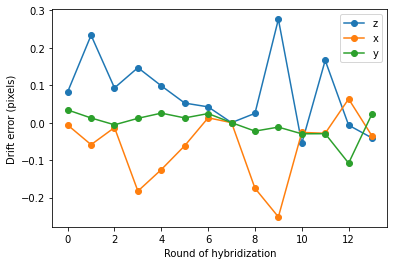

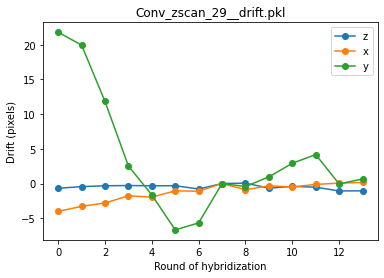

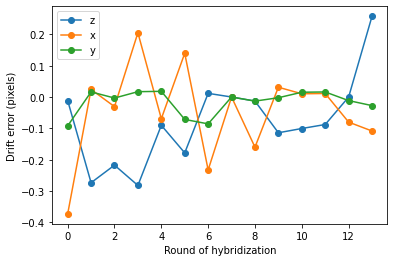

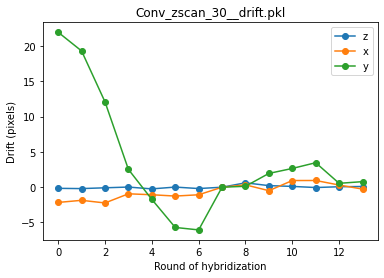

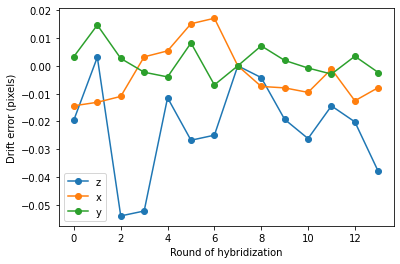

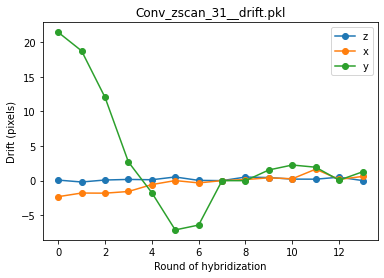

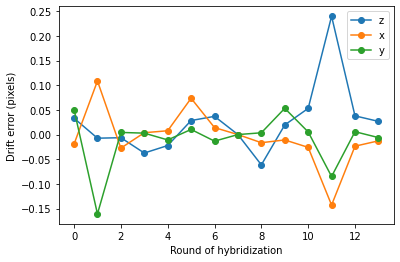

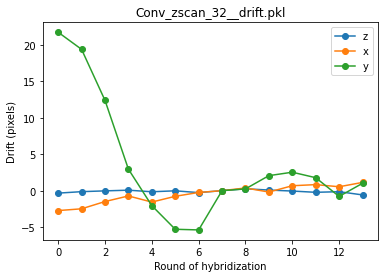

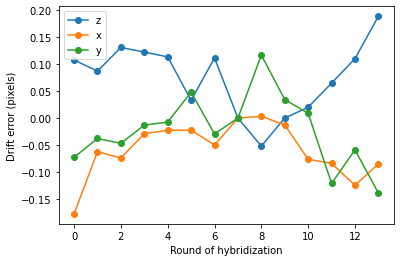

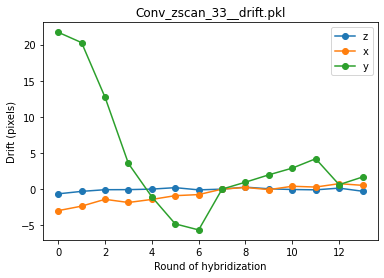

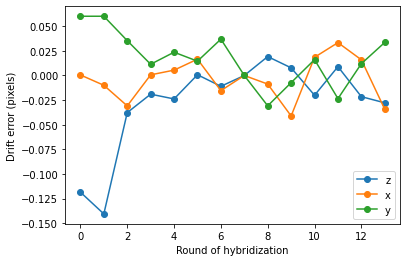

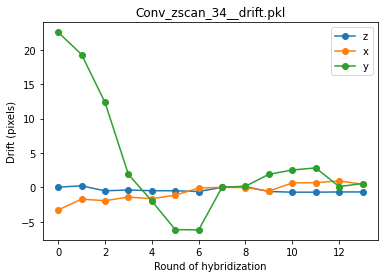

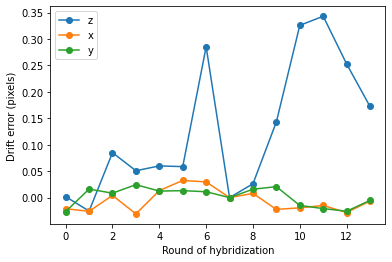

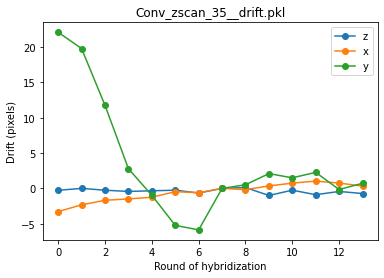

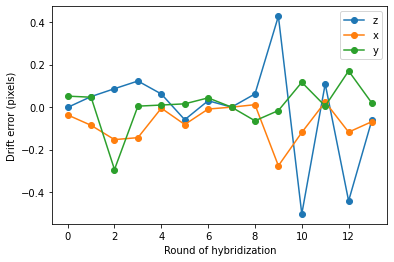

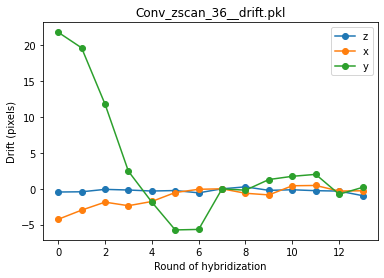

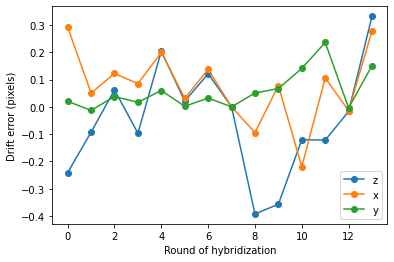

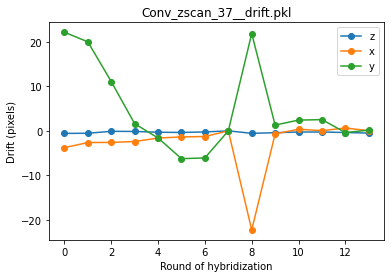

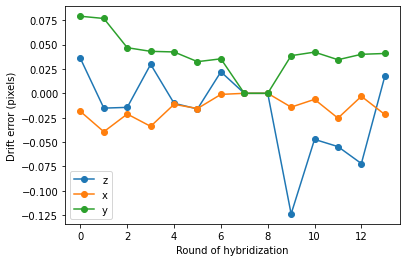

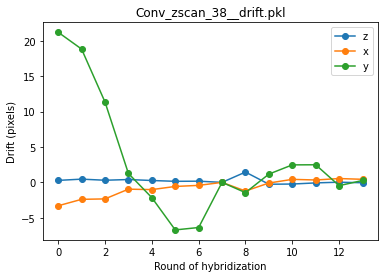

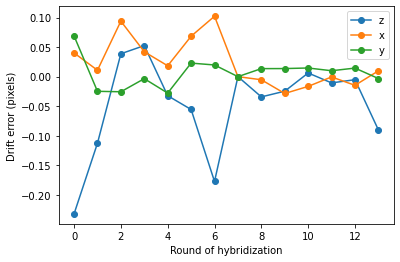

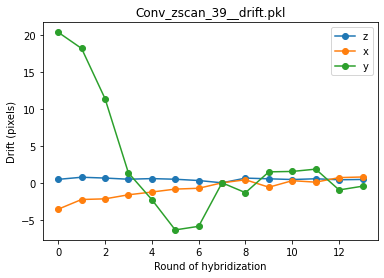

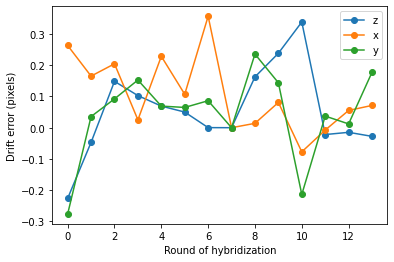

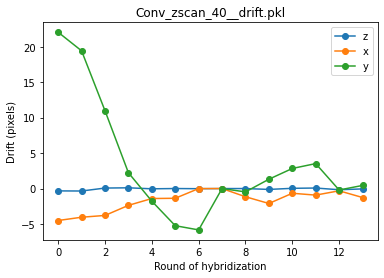

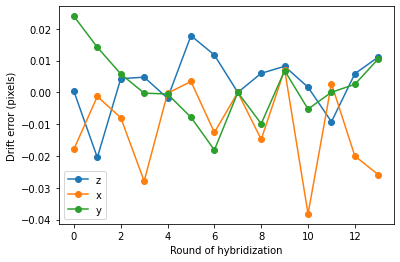

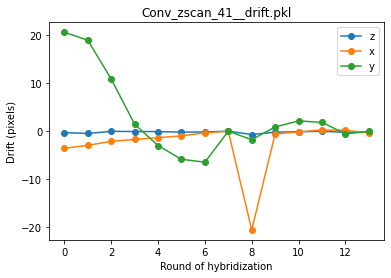

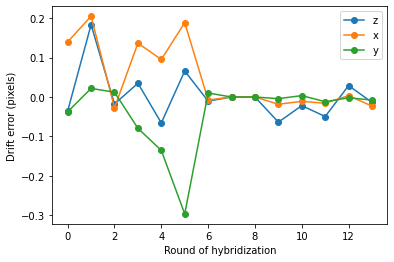

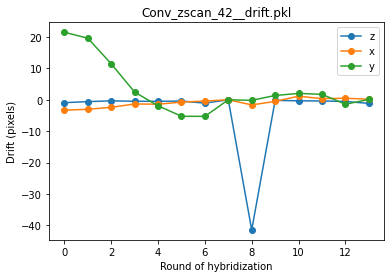

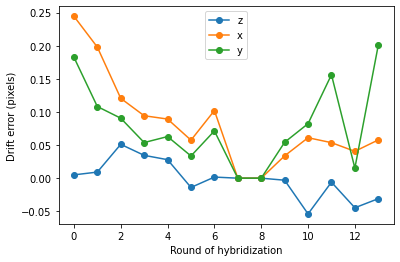

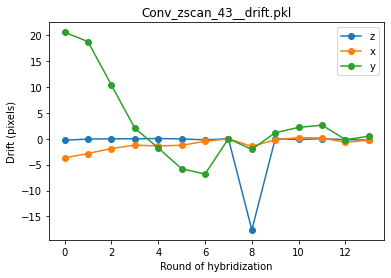

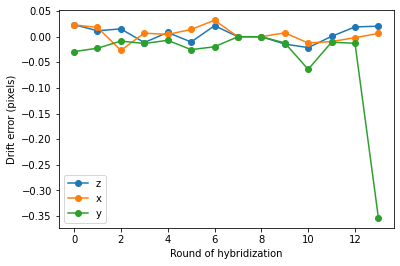

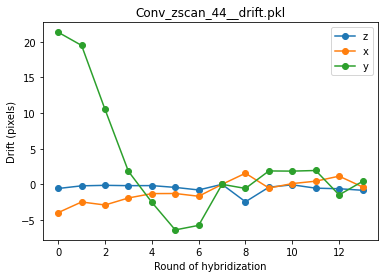

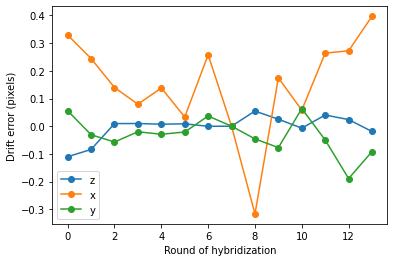

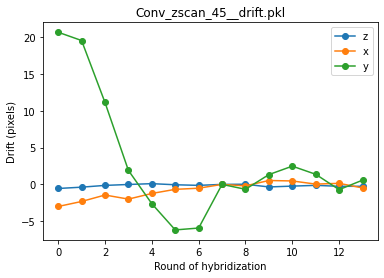

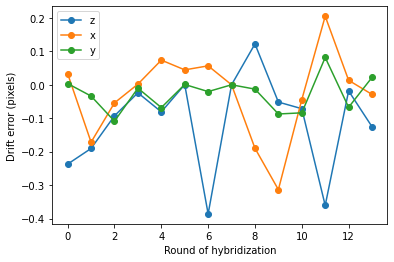

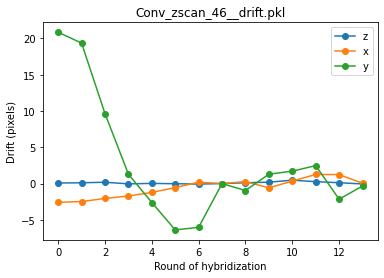

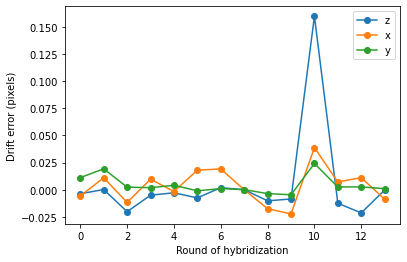

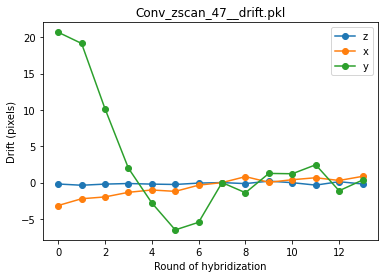

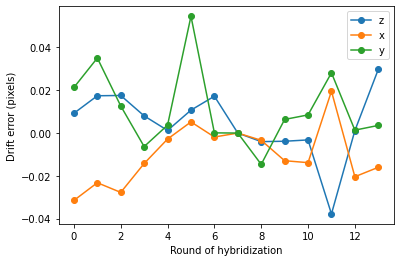

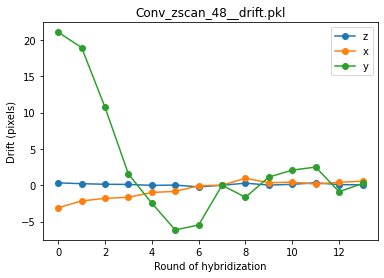

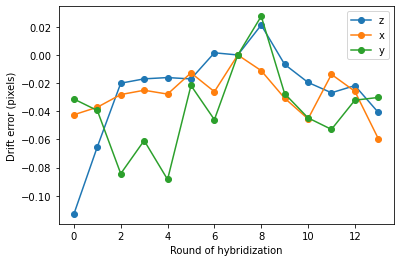

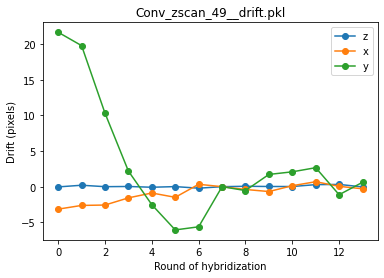

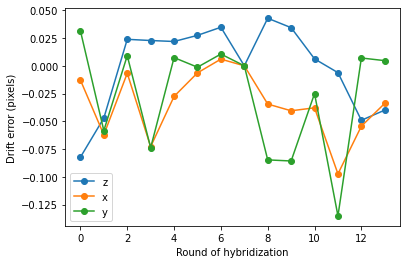

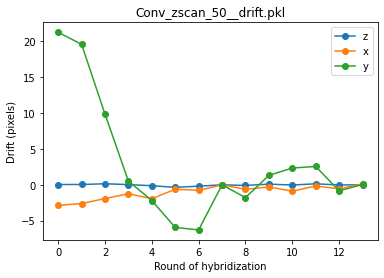

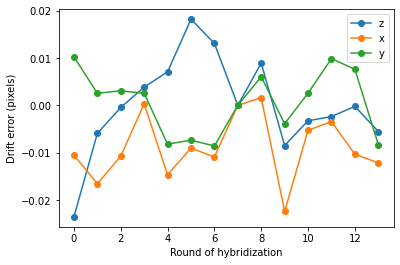

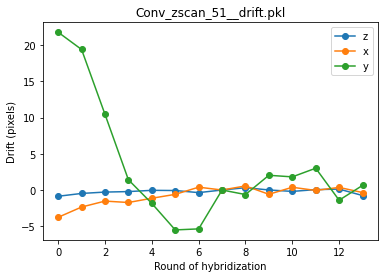

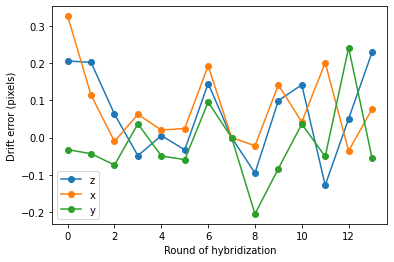

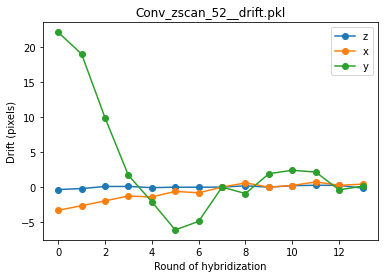

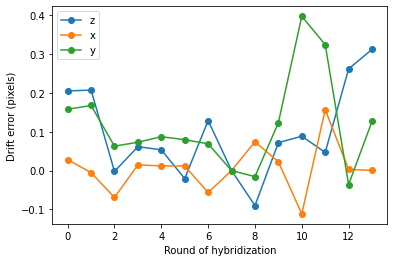

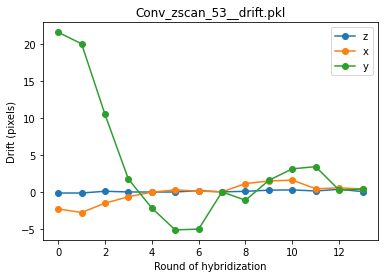

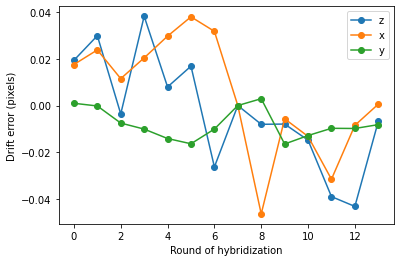

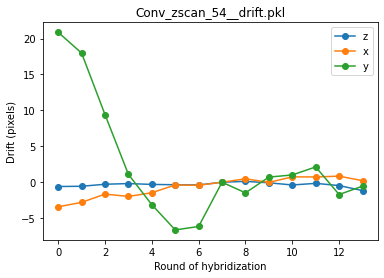

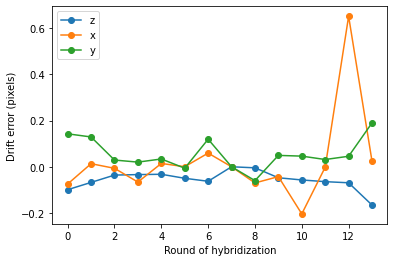

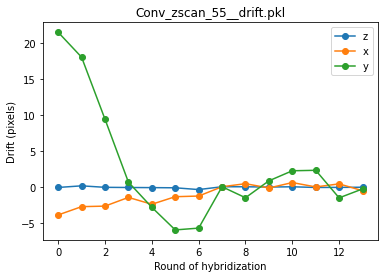

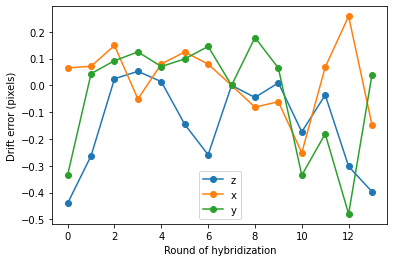

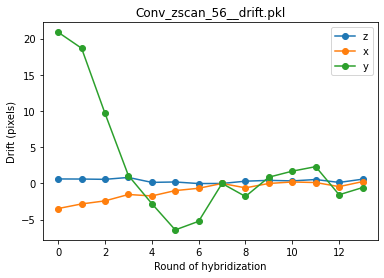

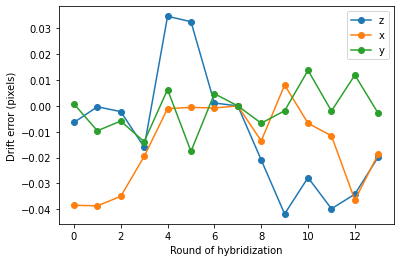

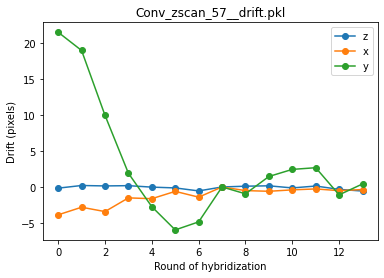

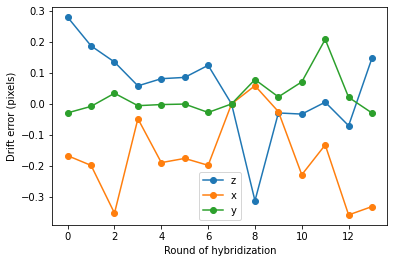

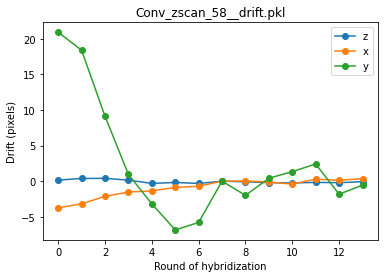

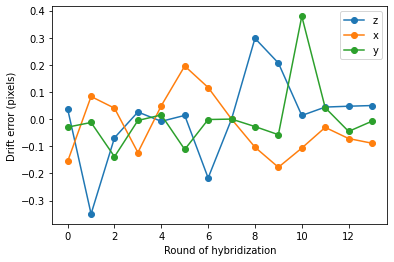

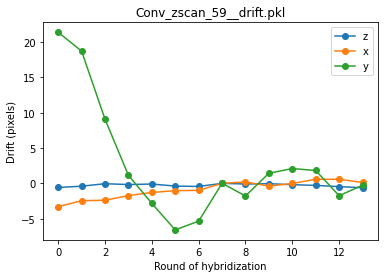

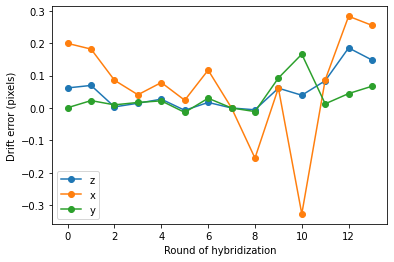

In [10]:
import glob
import pickle
import numpy as np
import os

#Plot drifts (optional?)
%matplotlib inline
fls = glob.glob(analysis_folder+r'\*drift.pkl')
for fl in fls:
    txyzs = np.array(pickle.load(open(fl,'rb'),encoding='latin1'))
    plt.figure()
    plt.title(os.path.basename(fl))
    for i in range(3):
        plt.plot(txyzs[:,0,i],'-o',label='zxy'[i])
    plt.xlabel('Round of hybridization')
    plt.ylabel('Drift (pixels)')
    plt.legend()
    plt.figure()
    plt.ylabel('Drift error (pixels)')
    for i in range(3):
        plt.plot(txyzs[:,1,i]-txyzs[:,0,i],'-o',label='zxy'[i])
    plt.xlabel('Round of hybridization')
    plt.legend()

### Perform EM algorithm

In [1589]:
import importlib
importlib.reload(pipeline)

<module 'PipelineFunctions' from 'C:\\Users\\Administrator\\Analysis\\ChromatinTracingPipeline_Underdev\\CommonTools\\PipelineFunctions.py'>

In [119]:
#Pretty fast, ~10 minutes
rounds = 42
zxys_f, hs_f, cols_f, snrs_f, scores_f, all_scores_f,  dic_spots, dic_drifts, dic_cell_ids, fovs_spots = pipeline.em_algorithm(analysis_folder, colors, rounds, blank_rounds=[25],
                                                                                                            chromatic_correction=r'D:\DNA_FISH\E20200110_D0021\BB_analysis\Post_analysis_nochrom_cor\chromatic_corr_BB_5_28_2020.pkl')

Loading candidates



Applying color correction



Initializing



----------------
EM iteration number:  1



fraction the same: 0.6130038674693992
fraction nan: 0.00027909572983533354
----------------
EM iteration number:  2



fraction the same: 0.8212425076086812
fraction nan: 0.00027909572983533354
----------------
EM iteration number:  3



fraction the same: 0.9243285089642891
fraction nan: 0.00027909572983533354
----------------
EM iteration number:  4



fraction the same: 0.9059746421594035
fraction nan: 0.00027909572983533354
----------------
EM iteration number:  5



fraction the same: 0.9728811982510001
fraction nan: 0.00027909572983533354
----------------
EM iteration number:  6



fraction the same: 0.9875436917719921
fraction nan: 0.00027909572983533354


In [120]:
post_analysis_folder = pipeline.make_post_analysis_folder(analysis_folder)

#### Make a histogram of scores for the data

In [121]:
%matplotlib inline
%matplotlib inline

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


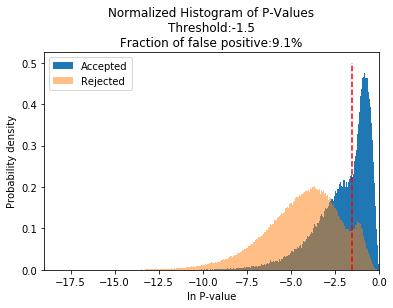

In [122]:
import numpy as np
#########
# a plot showing the overlap of the rejected spots (orange) versus the accepted ones (blue).
# the blue and orange should be separated susbstiantially, and we choose our threshold below based on this. (log scale) 

# Adjusting this cutoff 
cutoff_exp = -1.5

#########

scores_all_rav = []
nlen = np.max(list(map(len,all_scores_f)))
scores_all_reg = [[] for i in range(nlen)]
scores_all_bad = [[] for i in range(nlen)]
for scores_cell in all_scores_f:
    for ireg,scores_reg in enumerate(scores_cell):
        scores_all_reg[ireg].extend(scores_reg)
        scores_all_rav.extend(np.sort(scores_reg)[-4:-1]) # the 3 remaining spots after selecting the best
        scores_all_bad[ireg].extend(np.sort(scores_reg)[:-1])
vec = np.ravel(np.array(scores_f))
vec = vec[np.isnan(vec)==False]

fr = 1.*np.sum(scores_all_rav>np.exp(cutoff_exp))/len(scores_all_rav)
txt_ = "Fraction of false positive:"+str(np.round(fr*100,2))+'%'

fig = plt.figure()
plt.hist(np.log(vec),bins=1000,normed=True,label='Accepted')
plt.hist(np.log(scores_all_rav),bins=1000,alpha=0.5,normed=True,label='Rejected')
plt.vlines(cutoff_exp, 0, 0.5, 'r', linestyles='dashed')

plt.xlabel("ln P-value")
plt.ylabel("Probability density")
plt.legend()
plt.xlim((-19, 0))

plt.title("Normalized Histogram of P-Values"+'\n'+'Threshold:'+str(cutoff_exp)+'\n'+txt_);
fig.savefig(post_analysis_folder+'histogram_p-values.pdf')
fig.savefig(post_analysis_folder+'histogram_p-values.png')

<h4>Filter candidate chromosomes</h4>

In [123]:
############
number_of_segments = 42
max_segments_missing = 24
############
keep, zxys_clean_filtered, cell_ids_clean, hs_clean, scores_clean, fovs_spots_keep = pipeline.filter_chromosomes(number_of_segments,
                                                                                    max_segments_missing, zxys_f, hs_f, cols_f, 
                                                                                    scores_f, all_scores_f, dic_cell_ids, fovs_spots, 
                                                                                    cutoff_exp)

print("Chromosomes: "+str(len(zxys_clean_filtered)))

[196, 160, 228, 136, 226, 208, 180, 166, 138, 156, 134, 206, 176, 166, 206, 178, 196, 246, 234, 238, 188, 136, 132, 200, 218, 206, 146, 226, 218, 150, 170, 140, 148, 186, 152, 158, 150, 134, 154, 180]
7166
7166
Chromosomes: 4912


In [124]:
import importlib
import SimulateData as sd
importlib.reload(pipeline)

<module 'PipelineFunctions' from 'C:\\Users\\Administrator\\Analysis\\ChromatinTracingPipeline_Underdev\\CommonTools\\PipelineFunctions.py'>

In [125]:
zxys_clean_filtered, cell_ids_clean, chrs_keep = pipeline.top_two_chrs(zxys_clean_filtered, cell_ids_clean)
hs_clean = hs_clean[chrs_keep]
scores_clean = scores_clean[chrs_keep]
fovs_spots_keep = fovs_spots_keep[chrs_keep]
print("Chromosomes: "+str(len(zxys_clean_filtered)))

Chromosomes: 3558


<h3>Plot detection efficiency</h3>

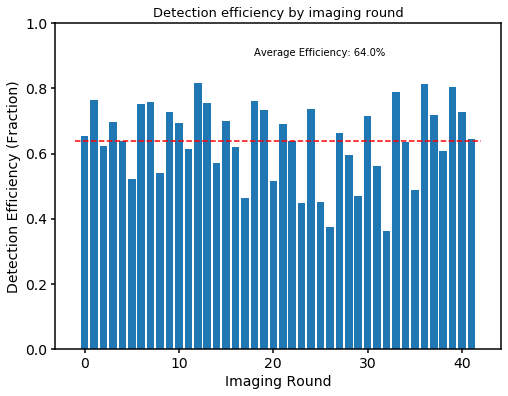

In [127]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.setp(ax.spines.values(), linewidth=1.5)
ax.tick_params(width=1.5, length=4, labelsize=14)
total_len = float(len(zxys_clean_filtered))
eff = [ 1-np.divide(float(np.sum(np.isnan(np.array(zxys_clean_filtered)[:,i,0]),axis=0)),total_len) 
       for i in range(zxys_clean_filtered.shape[1]) ]
plt.bar(range(0,42),eff)
plt.ylim((0.0,1.0))
plt.hlines(np.mean(eff), -1, 42, colors='r', linestyle='dashed')
plt.ylabel('Detection Efficiency (Fraction)', size=14)
plt.xlabel('Imaging Round', size=14)
plt.title("Detection efficiency by imaging round", size=13)
plt.text(18,0.9,"Average Efficiency: "+str(100*np.round(np.mean(eff),3))+"%")
plt.show()

fig.savefig(post_analysis_folder+'detection_efficiency.pdf')
fig.savefig(post_analysis_folder+'detection_efficiency.png')

### Median distance

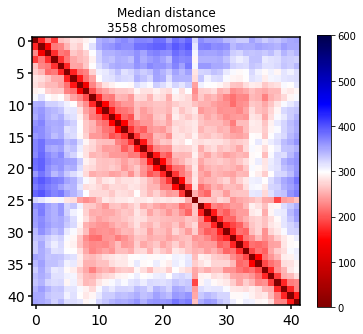

In [108]:
#########
vmin = 0  #Bottom of color scale (in nm)
vmax = 600  #Top of color scale (in nm)
#########

import os

zxys_clean_ = (zxys_clean_filtered)
mats_clean = np.array(list(map(squareform,list(map(pdist,zxys_clean_)))))

im = np.nanmedian(mats_clean[:,:42,:42],axis=0)# take the median image for the representative heatmap

%matplotlib inline
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.setp(ax.spines.values(), linewidth=1.5)
ax.tick_params(width=1.5, length=4, labelsize=14)
plt.title('Median distance\n'+str(len(zxys_clean_))+' chromosomes')
plt.imshow(im,vmin=vmin,vmax=vmax,cmap='seismic_r')
plt.colorbar()
fig.savefig(post_analysis_folder+'median_distance.pdf')
fig.savefig(post_analysis_folder+'median_distance.png')
np.save(analysis_folder+os.sep+r'AJ_combine_matrix.npy', mats_clean)

### Contact map

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater_equal
  


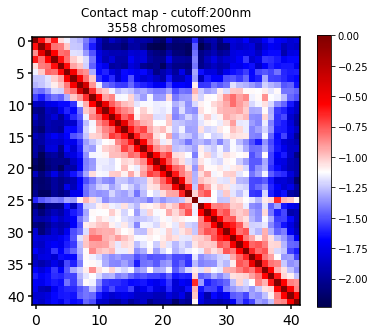

In [109]:
########
cutoff = 200  #Distance (nm) threshold for a contact
########

%matplotlib inline
mat_ = 1.*np.sum(mats_clean<cutoff,axis=0)/np.sum(mats_clean>=0,axis=0)
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.setp(ax.spines.values(), linewidth=1.5)
ax.tick_params(width=1.5, length=4, labelsize=14)
plt.title('Contact map - cutoff:'+str(cutoff)+'nm'+'\n'+str(len(mats_clean))+' chromosomes')
plt.imshow(np.log(mat_),cmap='seismic')
plt.colorbar()
fig.savefig(post_analysis_folder+'contact_map.pdf')
fig.savefig(post_analysis_folder+'contact_map.png')
np.save(analysis_folder+os.sep+r'AJ_combine_matrix_contact.npy', mats_clean)

<h3>Separate CAST and 129 alleles</h3>

In [128]:
import os
cell_names = []
cast_129_diff = 0.5

cell_ids = np.array(np.arange(len(zxys_f))/2,dtype=int) # create a list of length zxys, integer divide by 2 to make doubles
cell_ids_keep = cell_ids_clean
zyxs = zxys_clean_filtered.copy()
hs = hs_clean.copy()
hs[np.isnan(zyxs[:,:,0])]=np.nan
cids = cell_ids_keep.copy()
round_to_sort = 25
hmin=np.nanmedian(hs)/2

cids_,cts_= np.unique(cids,return_counts=True)
cids_kp = cids_[cts_==2] #indices of cells that have two remaining homologs
cell_ids_clean_, cids_clean_cts_ = np.unique(cell_ids_clean,return_counts=True)
cids_clean_kp = cell_ids_clean_[cids_clean_cts_==2]

zxys_cast = []
hs_cast = []
zxys_noncast = []
hs_noncast = []
cids_final = []
ignore = []
print("Ignoring " +str(len(ignore))+ " manually selected cells.")

for cid,cname in zip(cids_kp, cids_clean_kp):
    if cid in ignore:
        continue
    keep_homs = cids==cid
    zxy1,zxy2 = zyxs[keep_homs]
    h1s,h2s = hs[keep_homs,:]
    h1,h2 = h1s[round_to_sort],h2s[round_to_sort]
    if h1>hmin and not(h2>cast_129_diff*h1):
        zxys_cast.append(zxy1)
        hs_cast.append(h1s)
        zxys_noncast.append(zxy2)
        hs_noncast.append(h2s)
        cids_final.append(cid)
        cell_names.append(cname)
    if h2>hmin and not(h1>cast_129_diff*h2):
        cids_final.append(cid)
        zxys_cast.append(zxy2)
        hs_cast.append(h2s)
        zxys_noncast.append(zxy1)
        hs_noncast.append(h1s)
        cell_names.append(cname)
        
filename = analysis_folder+os.sep+"129_allele_coords.npy"
zxys_cast_corr = pipeline.meanCorrect3Col(np.array(zxys_cast))
np.save(filename, zxys_cast_corr)
filename = analysis_folder+os.sep+"cast_allele_coords.npy"
np.save(filename, pipeline.meanCorrect3Col(np.array(zxys_noncast)))
zxys_noncast_corr = pipeline.meanCorrect3Col(np.array(zxys_noncast))

print("Number of cells:",len(zxys_noncast))

Ignoring 0 manually selected cells.
Number of cells: 784


In [129]:
final_chrs = np.concatenate([zxys_noncast_corr, zxys_cast_corr])
cell_ids = np.concatenate([cids_final,cids_final])
counts = estimate_fp_fn(final_chrs, cell_ids)
np.save(analysis_folder+os.sep+r"final_coords.npy", final_chrs)
np.save(analysis_folder+os.sep+r"final_coords_cids.npy", cell_ids)

There are 0 cells with a false negative, 634 cells with one of each allele, and 150 cells with a false positive.


<h4>Set the font size and style for plots</h4>

In [1319]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['font.family']='Arial'

<h4>Plot: Median distance heatmap for CAST alleles</h4>

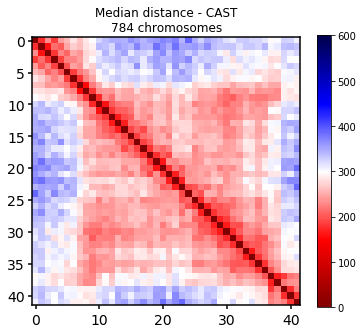

In [86]:
#########
vmin = 0  #Bottom of color scale (in nm)
vmax = 600  #Top of color scale (in nm)
#########

zxys_clean_ = (zxys_cast_corr)
mats_clean = np.array(list(map(squareform,list(map(pdist,zxys_clean_)))))

im = np.nanmedian(mats_clean[:,:42,:42],axis=0)# take the median image for the representative heatmap
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.setp(ax.spines.values(), linewidth=1.5)
ax.tick_params(width=1.5, length=4, labelsize=14)
plt.title('Median distance - CAST\n'+str(len(zxys_clean_))+' chromosomes')
plt.imshow(im,vmin=vmin,vmax=vmax,cmap='seismic_r')
plt.colorbar()
fig.savefig(post_analysis_folder+'median_distance-CAST.pdf')
fig.savefig(post_analysis_folder+'median_distance-CAST.png')
np.save(analysis_folder+os.sep+r'AJ_CAST_matrix.npy', im)

<h4>Plot: Median distance heatmap for 129 alleles</h4>

C:\Users\Administrator\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


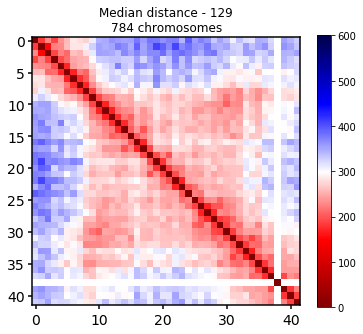

In [87]:
#########
vmin = 0  #Bottom of color scale (in nm)
vmax = 600  #Top of color scale (in nm)
#########

zxys_clean_ = (zxys_noncast_corr)
zxys_clean_[:,round_to_sort]=np.nan
mats_clean = np.array(list(map(squareform,list(map(pdist,zxys_clean_)))))

im_n = np.nanmedian(mats_clean[:,:42,:42],axis=0)# take the median image for the representative heatmap
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.setp(ax.spines.values(), linewidth=1.5)
ax.tick_params(width=1.5, length=4, labelsize=14)
plt.title('Median distance - 129\n'+str(len(zxys_clean_))+' chromosomes')
plt.imshow(im_n,vmin=vmin,vmax=vmax,cmap='seismic_r')
plt.colorbar()
fig.savefig(post_analysis_folder+'median_distance-129.pdf')
fig.savefig(post_analysis_folder+'median_distance-129.png')
np.save(analysis_folder+os.sep+r'AJ_129_matrix.npy', im_n)

<h4>Plot: Contact frequency heatmap for CAST alleles</h4>

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


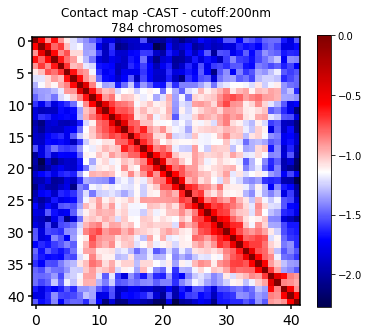

In [89]:
########
cutoff = 200  #Distance (nm) threshold for a contact
########

zxys_clean_ = (zxys_cast_corr)
mats_clean = np.array(list(map(squareform,list(map(pdist,zxys_clean_)))))

mat_ = 1.*np.sum(mats_clean<cutoff,axis=0)/np.sum(mats_clean>=0,axis=0)
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.setp(ax.spines.values(), linewidth=1.5)
ax.tick_params(width=1.5, length=4, labelsize=14)
plt.title('Contact map -CAST - cutoff:'+str(cutoff)+'nm'+'\n'+str(len(mats_clean))+' chromosomes')
ax = plt.imshow(np.log(mat_),cmap='seismic')
vmin,vmax = ax.get_clim()
plt.colorbar()
fig.savefig(post_analysis_folder+'contact_map-CAST.pdf')
fig.savefig(post_analysis_folder+'contact_map-CAST.png')
np.save(analysis_folder+os.sep+r'AJ_CAST_matrix_contact.npy', mat_)

<h4>Plot: Contact frequency heatmap for 129 alleles</h4>

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater_equal
  if sys.path[0] == '':
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


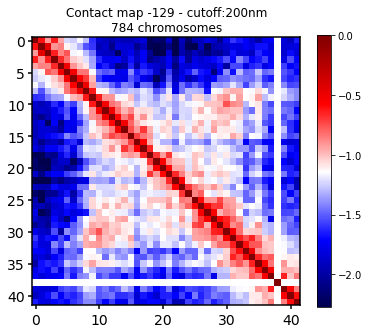

In [90]:
########
cutoff = 200  #Distance (nm) threshold for a contact
########

zxys_clean_ = pipeline.meanCorrect3Col(zxys_noncast_corr)
zxys_clean_[:,round_to_sort]=np.nan
mats_clean = np.array(list(map(squareform,list(map(pdist,zxys_clean_)))))

mat_n = 1.*np.sum(mats_clean<cutoff,axis=0)/np.sum(mats_clean>=0,axis=0)
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.setp(ax.spines.values(), linewidth=1.5)
ax.tick_params(width=1.5, length=4, labelsize=14)
plt.title('Contact map -129 - cutoff:'+str(cutoff)+'nm'+'\n'+str(len(mats_clean))+' chromosomes')
plt.imshow(np.log(mat_n),cmap='seismic',vmin=vmin,vmax=vmax)
plt.colorbar()
fig.savefig(post_analysis_folder+'contact_map-129.pdf')
fig.savefig(post_analysis_folder+'contact_map-129.png')
np.save(analysis_folder+os.sep+r'AJ_129_matrix_contact.npy', mat_n)

<h4>Plot: Difference of median distance (CAST-129)</h4>

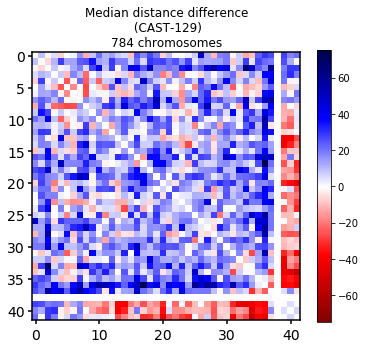

In [91]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.setp(ax.spines.values(), linewidth=1.5)
ax.tick_params(width=1.5, length=4, labelsize=14)
plt.title('Median distance difference\n (CAST-129)\n'+str(len(zxys_clean_))+' chromosomes')
plt.imshow(im_n-im,cmap='seismic_r',vmin=-75,vmax=75)
plt.colorbar();
fig.savefig(post_analysis_folder+'diff_of_medians.pdf')
fig.savefig(post_analysis_folder+'diff_of_medians.png')

<h4>Plot: Log-difference of contact frequency (CAST-129)</h4>

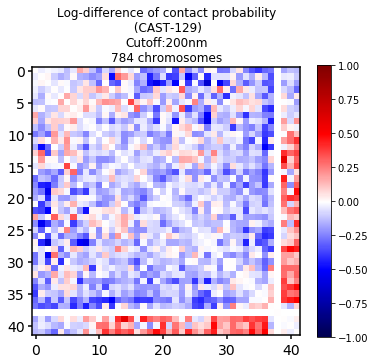

In [92]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.setp(ax.spines.values(), linewidth=1.5)
ax.tick_params(width=1.5, length=4, labelsize=14)
plt.title('Log-difference of contact probability\n (CAST-129)\n'+'Cutoff:'+str(cutoff)+'nm\n'+str(len(zxys_clean_))+' chromosomes')
plt.imshow(np.log(mat_n)-np.log(mat_),cmap='seismic', vmax=1.0, vmin=-1.0)
plt.colorbar()
fig.savefig(post_analysis_folder+'log_diff_contact.pdf')
fig.savefig(post_analysis_folder+'log_diff_contact.png')

<h3>Single-cell analysis</h3>

<h4>Enhancer-promoter distance comparison between alleles</h4>

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


232.16396367325495
242.55620864124154


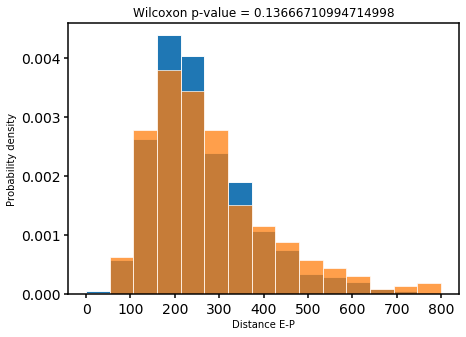

In [93]:
#########
p = [8,9,10]     #Segments that include the promoter (counting from 0)
e = [30,31,32]   #Segments that include the super-enhancer (counting from 0)
#########

def get_dists(zxys):
    dists_ep = []
    for p_i in p:
        for e_i in e:
            p_ = np.nanmedian(np.array(zxys)[:,[p_i]],axis=1)#if feature spans multiple regions get the mean position
            e_ = np.nanmedian(np.array(zxys)[:,[e_i]],axis=1)
            dists_ep.append(np.linalg.norm(p_-e_,axis=-1))

    dists_ep = np.nanmedian(dists_ep,axis=0)
    dists_ep = dists_ep[~np.isnan(dists_ep)]#keep valid distances
    return dists_ep

dists_ep_cast = get_dists(zxys_cast)
dists_ep_noncast = get_dists(zxys_noncast)
savepath = post_analysis_folder+os.sep+r'cast_e24.npy'
np.save(savepath, dists_ep_cast)
savepath = post_analysis_folder+os.sep+r'noncast_e24.npy'
np.save(savepath, dists_ep_noncast)

res = ranksums(dists_ep_cast,dists_ep_noncast)
pvalue = res[-1]
pvalue

bins=np.linspace(0,800,16)
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
plt.setp(ax.spines.values(), linewidth=1.5)
ax.tick_params(width=1.5, length=4, labelsize=14)
plt.hist(dists_ep_cast,bins=bins,normed=True,label='CAST (median = {:.0f}nm)'.format(np.nanmedian(dists_ep_cast)), edgecolor='white', linewidth=0.9);
plt.hist(dists_ep_noncast,bins=bins,normed=True,alpha=0.75,label='129 (median = {:.0f}nm)'.format(np.nanmedian(dists_ep_noncast)), edgecolor='white', linewidth=0.9);
#plt.legend()
plt.title("Wilcoxon p-value = {}".format(pvalue))
plt.xlabel('Distance E-P')
plt.ylabel('Probability density')
plt.savefig(post_analysis_folder+'enh_prom_distance.pdf',dpi=300,bbox_inches="tight")
plt.savefig(post_analysis_folder+'enh_prom_distance.png',dpi=300,bbox_inches="tight")
print(np.nanmedian(dists_ep_cast))
print(np.nanmedian(dists_ep_noncast))

<h4>Enhancer-promoter contact comparison</h4>

In [94]:
#########
contact_distance = 200   #Distance (nm) threshold for contact
#########

cast_fraction = 1.*np.sum(dists_ep_cast<contact_distance)/np.sum(dists_ep_cast>=0)
noncast_fraction = 1.*np.sum(dists_ep_noncast<contact_distance)/np.sum(dists_ep_noncast>=0)
#Fisher's exact test for contact <150nm
from scipy.stats import fisher_exact
cast_contact = np.sum(dists_ep_cast<=150)
cast_none = np.sum(dists_ep_cast>150)
wt_contact = np.sum(dists_ep_noncast<=150)
wt_none = np.sum(dists_ep_noncast>150)
print(f"\t<={contact_distance}\t>{contact_distance}")
print(f"CAST\t{cast_contact}\t{cast_none}")
print(f"129\t{wt_contact}\t{wt_none}")
table = [[cast_contact,cast_none],[wt_contact,wt_none]]
oddsratio, pvalue = fisher_exact(table)
print("\nFisher exact test")
print(f"Odds ratio: {oddsratio}")
print(f"P-value: {pvalue}")

	<=200	>200
CAST	97	559
129	100	584

Fisher exact test
Odds ratio: 1.013381037567084
P-value: 0.9386528604383195


C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


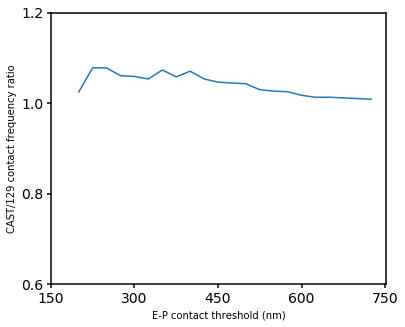

In [95]:
#########
minimum = 200
maximum = 750
step = 25
#########

import seaborn as sns

def enh_prom_distance_ratio(threshold):
    cast_contact = np.sum(dists_ep_cast<=threshold)
    cast_none = np.sum(dists_ep_cast>threshold)
    wt_contact = np.sum(dists_ep_noncast<=threshold)
    wt_none = np.sum(dists_ep_noncast>threshold)
    return (float(cast_contact) / (cast_contact+cast_none)) / (float(wt_contact) / (wt_contact+wt_none))

dists = list(range(minimum,maximum,step))
ratio_nums = [enh_prom_distance_ratio(thresh) for thresh in dists]
#smoothing
#smooth = [sum(ratio_nums[i-25:i+26]) / 51.0 for i in range(105,650)]
fig = plt.figure(figsize=(6,5))
plt.xlabel("E-P contact threshold (nm)")
plt.ylabel("CAST/129 contact frequency ratio")
sns.lineplot(dists, ratio_nums)
ax = fig.add_subplot(111)
plt.setp(ax.spines.values(), linewidth=1.5)
ax.tick_params(width=1.5, length=4, labelsize=14)

plt.ylim(0.6,1.2)
plt.yticks([0.6,0.8,1.0,1.2])
plt.xticks([150,300,450,600,750]);
plt.savefig(post_analysis_folder+'ep_threshold.pdf',dpi=300,bbox_inches="tight")
plt.savefig(post_analysis_folder+'ep_threshold.png',dpi=300,bbox_inches="tight")

<h4>Radius of gyration</h4>

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


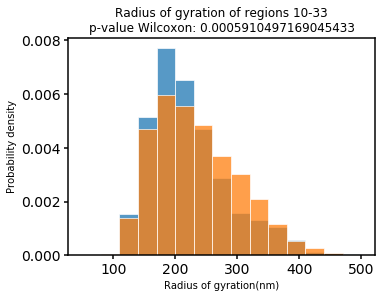

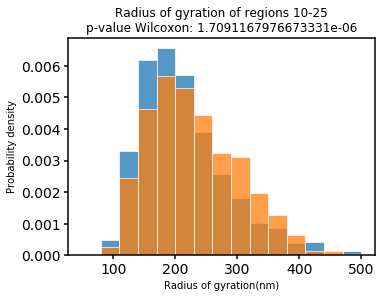

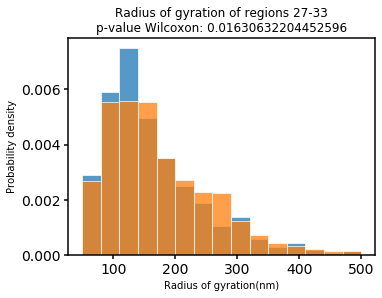

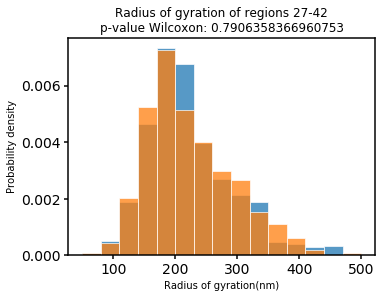

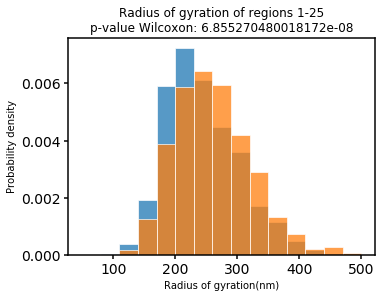

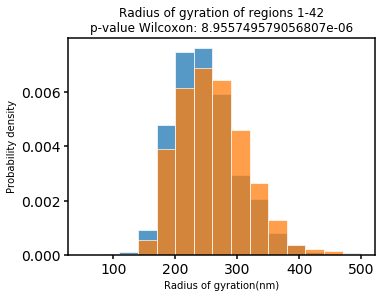

In [96]:
########
regions_to_plot = [(9,33), (9,25), (26,33), (26,42), (0,25), (0,42)]
########

def get_rgs(zxys_cast_,remove_nan=True):
    zxys_cast_ -= np.nanmean(zxys_cast_,axis=1)[:,np.newaxis]
    zxys_cast_ = np.linalg.norm(zxys_cast_,axis=-1)
    rg_cats = np.sqrt(np.nanmean(zxys_cast_**2,axis=-1))
    if remove_nan:
        rg_cats = rg_cats[~np.isnan(rg_cats)]
    return rg_cats


def histogram_rgs(zxys_cast,zxys_noncast,edges=[9,33],bins=np.linspace(50,500,16)):
    e1,e2 = edges
    zxys_cast_ = np.array(zxys_cast)[:,e1:e2].copy()
    rgs_cast = get_rgs(zxys_cast_)
    zxys_noncast_ = np.array(zxys_noncast)[:,e1:e2].copy()
    rgs_noncast = get_rgs(zxys_noncast_)
    fig = plt.figure(figsize=(5.5,4))
    ax = fig.add_subplot(111)
    plt.setp(ax.spines.values(), linewidth=1.5)
    ax.tick_params(width=1.5, length=4, labelsize=14)
    
    plt.hist(rgs_cast,bins=bins,normed=True,alpha=0.75,label='CAST - median(nm):'+str(int(np.median(rgs_cast))), edgecolor='white', linewidth=0.9)
    plt.hist(rgs_noncast,bins=bins,normed=True,alpha=0.75,label='129 - median(nm):'+str(int(np.median(rgs_noncast))), edgecolor='white', linewidth=0.9)
    #plt.legend()
    plt.ylabel("Probability density")
    plt.xlabel("Radius of gyration(nm)")
    res = ranksums(rgs_cast,rgs_noncast)
    pvalue = res[-1]
    plt.title('Radius of gyration of regions '+str(e1+1)+'-'+str(e2)+'\np-value Wilcoxon: '+str(pvalue))
    fig.savefig(post_analysis_folder+'radiusgyration_'+str(e1+1)+'-'+str(e2)+'.pdf',dpi=300,bbox_inches="tight")
    fig.savefig(post_analysis_folder+'radiusgyration_'+str(e1+1)+'-'+str(e2)+'.png',dpi=300,bbox_inches="tight")
    return fig,rgs_cast,rgs_noncast

for region in regions_to_plot:
    histogram_rgs(zxys_cast,zxys_noncast,edges=region,bins=np.linspace(50,500,16));

<h4>Insulation of domains</h4>

In [137]:
#########
#Insulation of regions start-middle and middle-end
start = 9
middle = 25
end = 33
#########

def get_insulation(zxys,a,b,c,func=np.nanmedian):
    distances_in_domAB_and_domBC = np.array([list(pdist(zxy_[a:b]))+list(pdist(zxy_[b:c])) for zxy_ in zxys])
    distances_between_domains = np.array([cdist(zxy_[a:b],zxy_[b:c]).ravel() for zxy_ in zxys])
    insulation = func(distances_between_domains,axis=-1)/func(distances_in_domAB_and_domBC,axis=-1)
    insulation = insulation[~np.isnan(insulation)]
    return insulation

def insulation_figure(zxys_cast,zxys_noncast,a,b,c,bins = np.linspace(-1,1,30)):
    ins_CAST = np.log(get_insulation(zxys_cast,a,b,c))
    ins_129 = np.log(get_insulation(zxys_noncast,a,b,c))
    fig =  plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    plt.setp(ax.spines.values(), linewidth=1.5)
    ax.tick_params(width=1.5, length=4, labelsize=14)
    plt.hist(ins_CAST,normed=True,bins=bins,alpha=0.75,label='CAST - median:'+str(np.round(np.median(ins_CAST),2)), edgecolor='white', linewidth=0.9)
    plt.hist(ins_129,normed=True,bins=bins,alpha=0.75,label='129 - median:'+str(np.round(np.median(ins_129),2)), edgecolor='white', linewidth=0.9)
    plt.xlabel('Log-insulation\n Insulation - median distances between domains/median distance within domains')
    plt.ylabel('Prbability density\nacross cells')
    #plt.legend()
    res = ranksums(ins_CAST,ins_129)
    pvalue = res[-1]
    
    plt.title('Single cell insulation of domains '+str((a+1,b))+'- '+str((b+1,c))+'\np-value -wilcoxon:'+str(pvalue))
    fig.savefig(post_analysis_folder+'insulation.pdf',dpi=300,bbox_inches="tight")
    fig.savefig(post_analysis_folder+'insulation.png',dpi=300,bbox_inches="tight")
    return fig,ins_CAST,ins_129

zxys_cast = np.array(zxys_cast)
zxys_noncast = np.array(zxys_noncast)

fig,ins_CAST,ins_129 = insulation_figure(np.insert(np.delete(zxys_cast, 25, 1),38, zxys_cast[:,25,:]),np.insert(np.delete(zxys_noncast, 25, 1), 38, zxys_noncast[:,25,:]),start,middle,end)

ValueError: could not broadcast input array from shape (784,3) into shape (784)

In [98]:
import DomainTools as dt
dom_sz = 6
cutoff = 0.33
dom_starts_all_cast = []
for zxy_ in (zxys_cast):

    bad = np.where(np.isnan(zxy_[:,0]))[0]
    zxy__ = np.array([dt.interp1dnan(x_) for x_ in zxy_.T]).T

    zxy___ = zxy__
    
    #get initial guess of where a domains boundary is
    dists = np.array([np.linalg.norm(np.nanmean(zxy___[max(i-dom_sz,0):i],axis=0)-\
                            np.nanmean(zxy___[i:i+dom_sz],axis=0)) 
                              for i in range(len(zxy___))])
    bds = dt.get_ind_loc_max(dists,cutoff_max=0,valley=dom_sz)
    dom_starts= [0]+[dm for dm in bds if dm>1 and dm<len(zxy___)-2]
    mat = squareform(pdist(zxy___))
    dom_starts_ = dom_starts
    # fuse domains untill cannot fuse anymore based on cutoff.
    if len(dom_starts)>1:
        dom_starts_,seps = dt.fuse_doms(mat,dom_starts,tag='median',cut_off=cutoff)
    dom_starts_all_cast+=[dom_starts_[1:]]
    if False:
        plt.figure()
        plt.imshow(mat,vmax=800,cmap='seismic_r')
        plt.plot(dom_starts_,dom_starts_,'go')
        
dom_starts_all_noncast = []
for zxy_ in (zxys_noncast):

    bad = np.where(np.isnan(zxy_[:,0]))[0]
    zxy__ = np.array([dt.interp1dnan(x_) for x_ in zxy_.T]).T

    zxy___ = zxy__
    dists = np.array([np.linalg.norm(np.nanmean(zxy___[max(i-dom_sz,0):i],axis=0)-\
                            np.nanmean(zxy___[i:i+dom_sz],axis=0)) 
                              for i in range(len(zxy___))])
    bds = dt.get_ind_loc_max(dists,cutoff_max=0,valley=dom_sz)
    dom_starts= [0]+[dm for dm in bds if dm>1 and dm<len(zxy___)-2]
    mat = squareform(pdist(zxy___))
    dom_starts_ = dom_starts
    if len(dom_starts)>1:
        dom_starts_,seps = dt.fuse_doms(mat,dom_starts,tag='median',cut_off=cutoff)
    dom_starts_all_noncast+=[dom_starts_[1:]]
    if False:
        plt.figure()
        plt.imshow(mat,vmax=800,cmap='seismic_r')
        plt.plot(dom_starts_,dom_starts_,'go')

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice


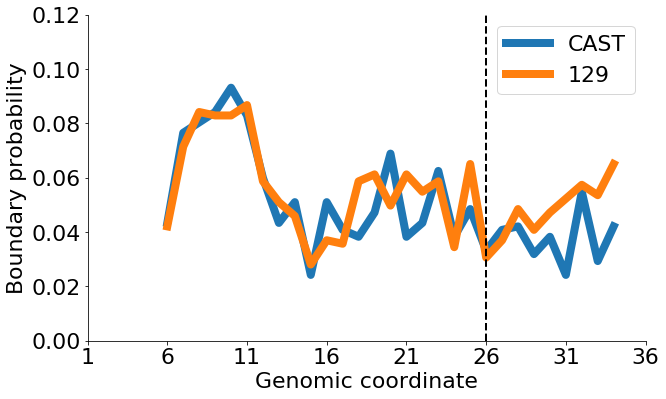

In [99]:
bds_all = [e for dm in dom_starts_all_cast for e in dm]
fig = dt.fig_no_axis(figsize=(10,6))
fracs = np.bincount(bds_all)/float(len(dom_starts_all_cast))
fracs[:dom_sz-1]=np.nan
fracs[-dom_sz+1:]=np.nan
#fracs = np.insert(np.delete(fracs, 25), 38, np.nan)

plt.plot(fracs,'.-',label='CAST', linewidth=8)
bds_all = [e for dm in dom_starts_all_noncast for e in dm]
fracs = np.bincount(bds_all)/float(len(dom_starts_all_noncast))
fracs[:dom_sz-1]=np.nan
fracs[-dom_sz+1:]=np.nan
#fracs = np.insert(np.delete(fracs, 25), 38, np.nan)

plt.plot(fracs,'.-',label='129', linewidth=8)
plt.xticks(np.arange(fracs.shape[0],step=5), np.arange(1,fracs.shape[0]+1,step=5))
plt.ylabel('Boundary probability')
plt.xlabel('Genomic coordinate')
plt.axvline(25,linestyle='--', color='black',linewidth=2)
plt.ylim(0,0.12)
plt.legend()
filename = post_analysis_folder+os.sep+r'\Bondary_prob_e21.pdf'
plt.savefig(filename, format='pdf', dpi=400)
filename = post_analysis_folder+os.sep+r'\Bondary_prob_e21.png'
plt.savefig(filename, format='png', dpi=400)